In [1]:
#!pip install qiskit

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, BasicAer, IBMQ, transpile, assemble
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
from qiskit.tools.visualization import circuit_drawer
#from qiskit.quantum_info import state_fidelity
import numpy as np
from random import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
#provider = IBMQ.load_account()
print("Libraries Imported Successfully!")

Libraries Imported Successfully!


# Shor Code

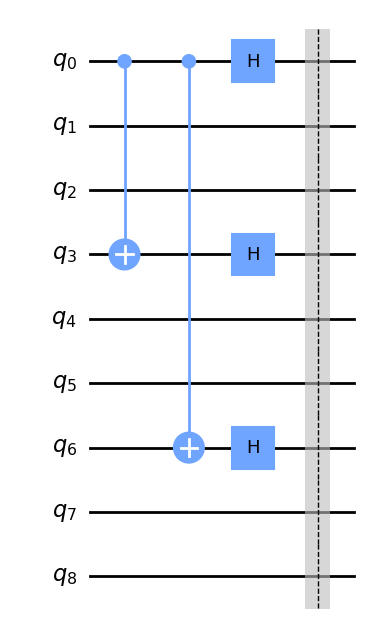

In [2]:
phaseflip_encode = QuantumCircuit(9)
phaseflip_encode.cx(0,3)
phaseflip_encode.cx(0,6)
phaseflip_encode.h(0)
phaseflip_encode.h(3)
phaseflip_encode.h(6)
phaseflip_encode.barrier()
phaseflip_encode.draw('mpl')

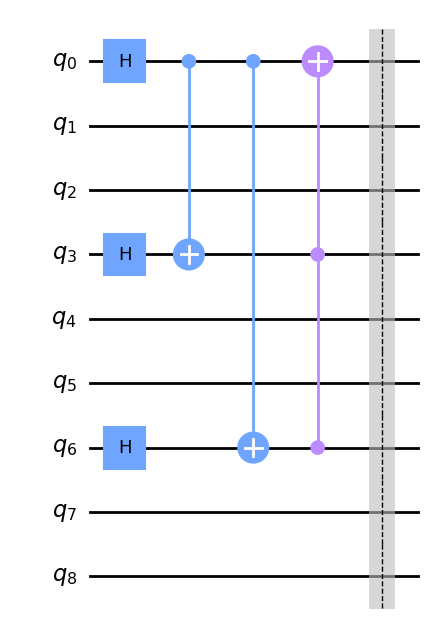

In [3]:
phaseflip_correct = QuantumCircuit(9)
phaseflip_correct.h(0)
phaseflip_correct.h(3)
phaseflip_correct.h(6)
phaseflip_correct.cx(0,3)
phaseflip_correct.cx(0,6)
phaseflip_correct.ccx(6,3,0)
phaseflip_correct.barrier()
phaseflip_correct.draw('mpl')

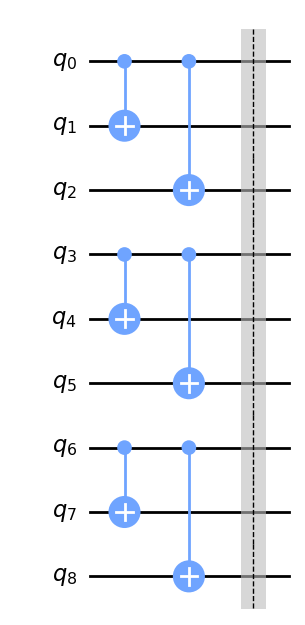

In [4]:
bitflip_encode = QuantumCircuit(9)
bitflip_encode.cx(0,1)
bitflip_encode.cx(0,2)
bitflip_encode.cx(3,4)
bitflip_encode.cx(3,5)
bitflip_encode.cx(6,7)
bitflip_encode.cx(6,8)
bitflip_encode.barrier()
bitflip_encode.draw('mpl')

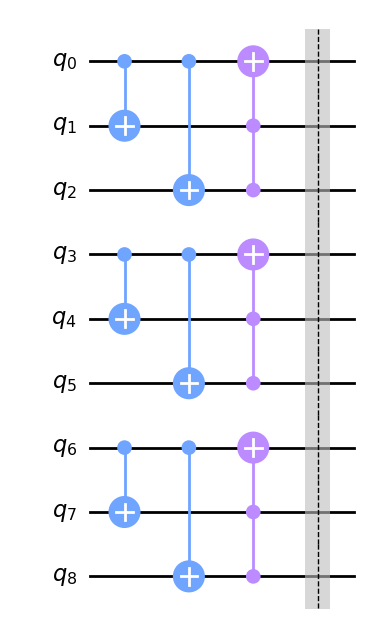

In [5]:
bitflip_correct = QuantumCircuit(9)
bitflip_correct.cx(0,1)
bitflip_correct.cx(0,2)
bitflip_correct.ccx(2,1,0)
bitflip_correct.cx(3,4)
bitflip_correct.cx(3,5)
bitflip_correct.ccx(5,4,3)
bitflip_correct.cx(6,7)
bitflip_correct.cx(6,8)
bitflip_correct.ccx(8,7,6)
bitflip_correct.barrier()
bitflip_correct.draw('mpl')

In [6]:
shor_encode = QuantumCircuit(9)
shor_encode = shor_encode.compose(phaseflip_encode, qubits = [0,1,2,3,4,5,6,7,8])
shor_encode = shor_encode.compose(bitflip_encode, qubits = [0,1,2,3,4,5,6,7,8])
shor_correct = QuantumCircuit(9)
shor_correct = shor_correct.compose(bitflip_correct, qubits = [0,1,2,3,4,5,6,7,8])
shor_correct = shor_correct.compose(phaseflip_correct, qubits = [0,1,2,3,4,5,6,7,8])

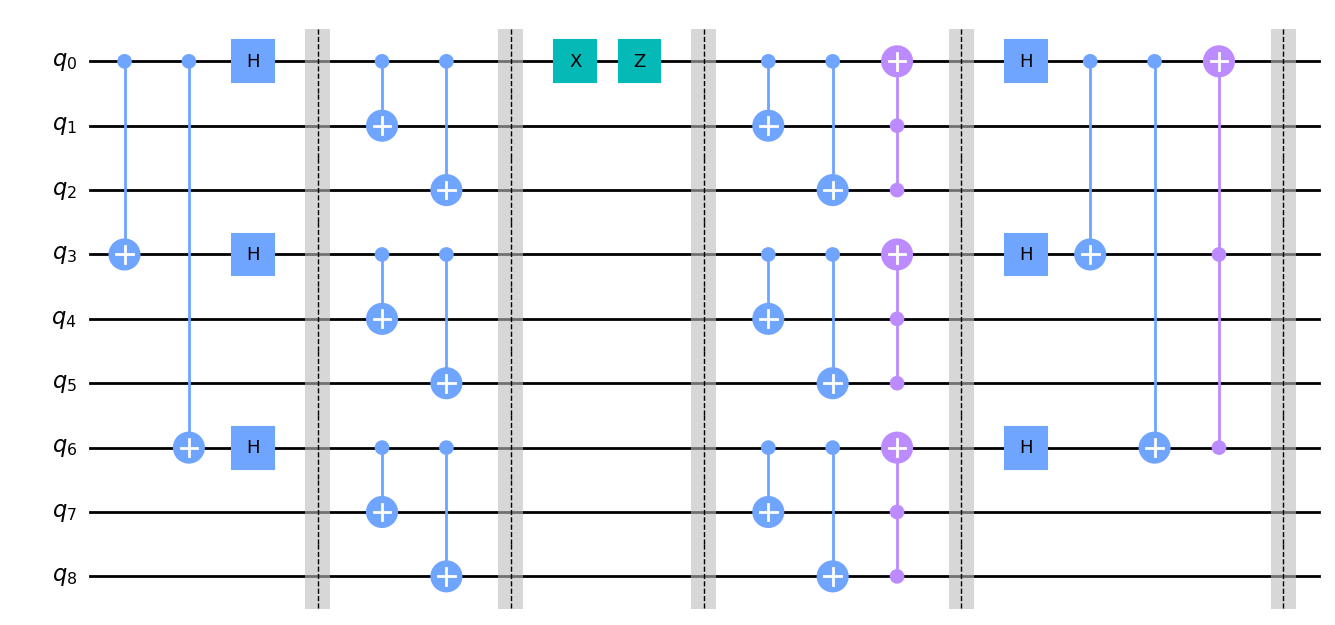

In [7]:
full_code = QuantumCircuit(9)
#==========
# ENCODING
#==========
# Prepare the initial state and save its statevector
# Prepare in the |0> state
initial_state = Statevector.from_instruction(full_code)
initial_state = partial_trace(initial_state, [1, 2, 3, 4, 5, 6, 7, 8]).to_statevector()
full_code = full_code.compose(shor_encode, qubits = [0, 1, 2, 3, 4, 5, 6, 7, 8])
#full_code.barrier()
#==========
# ERRORS
#==========
full_code.x(0)
full_code.z(0)
full_code.barrier()

#==========================
# DETECTION AND CORRECTION
#==========================
full_code = full_code.compose(shor_correct, qubits = [0, 1, 2, 3, 4, 5, 6, 7, 8])
# Save the final statevector for comparison to the initial one
final_state = Statevector.from_instruction(full_code)
final_state = partial_trace(final_state, [1, 2, 3, 4, 5, 6, 7, 8]).to_statevector()
 
full_code.draw('mpl')

In [8]:
initial_state.equiv(final_state)

True

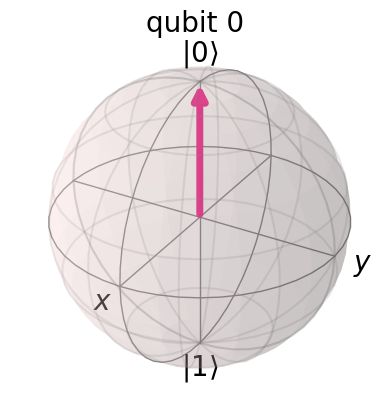

In [9]:
initial_state.draw(output = 'bloch')

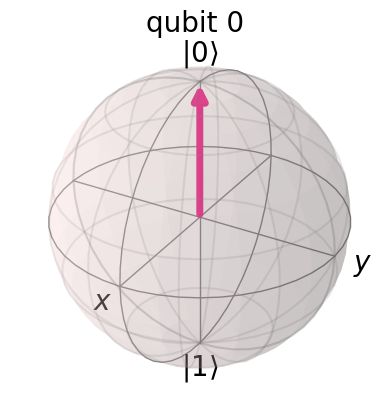

In [10]:
final_state.draw(output = 'bloch')

In [11]:
def get_fidelity(probability):
    #probability = 0.10

    # COMPLETE THIS CODE
    full_code = QuantumCircuit(9)

    #==========
    # ENCODING
    #==========
    # Prepare the initial state and save its statevector
    # Prepare in the |0> state

    initial_state = Statevector.from_instruction(full_code)
    initial_state = partial_trace(initial_state, [1, 2, 3, 4, 5, 6, 7, 8]).to_statevector()

    full_code = full_code.compose(shor_encode, qubits = [0, 1, 2, 3, 4, 5, 6, 7, 8])
    #full_code.barrier()
    #==========
    # ERRORS
    #==========
    for i in range(9):
      if random() < probability:
        full_code.x(i)
      if random() < probability:
        full_code.z(i)
    full_code.barrier()
    #==========================
    # DETECTION AND CORRECTION
    #==========================

    full_code = full_code.compose(shor_correct, qubits = [0, 1, 2, 3, 4, 5, 6, 7, 8])

    # Save the final statevector for comparison to the initial one
    final_state = Statevector.from_instruction(full_code)
    final_state = partial_trace(final_state, [1, 2, 3, 4, 5, 6, 7, 8]).to_statevector()

    full_code.draw()
    return state_fidelity(initial_state, final_state)

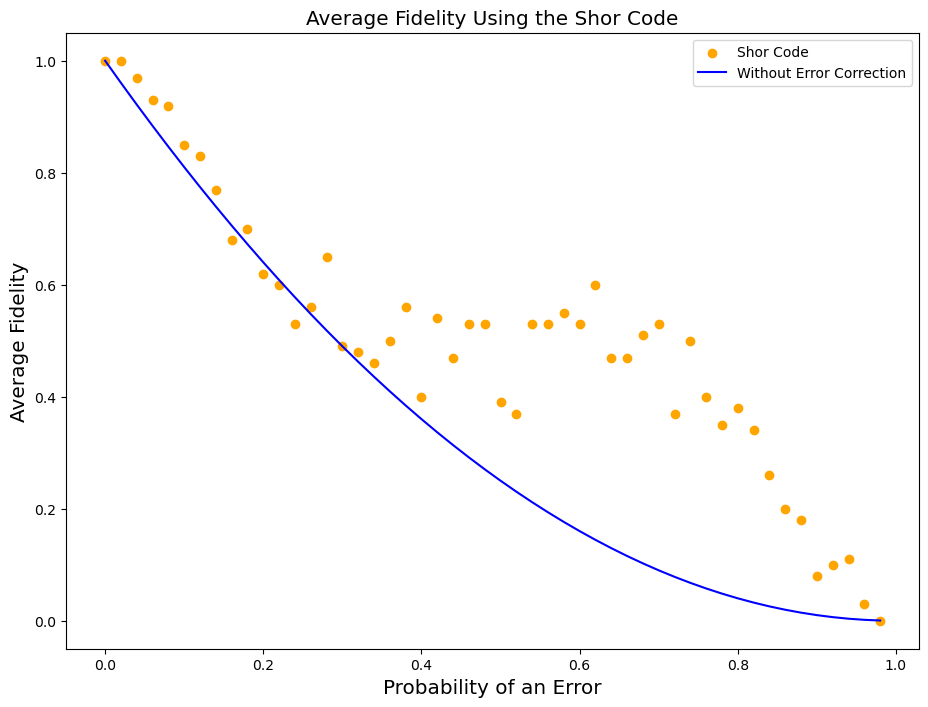

In [12]:
num_points = 50
num_trials_per_point = 100
average_fidelities_shor = []
probabilities = [p / num_points for p in range(num_points)]

for probability in probabilities:
  average_fidelity = 0
  for trial in range(num_trials_per_point):
    average_fidelity += get_fidelity(probability)
  average_fidelity /= num_trials_per_point
  average_fidelities_shor  += [average_fidelity]

plt.figure(figsize = (11, 8))
plt.scatter(probabilities, average_fidelities_shor, label = 'Shor Code', color = 'orange')
plt.plot(probabilities, [(1 - p)**2 for p in probabilities], label = 'Without Error Correction', color = 'blue')


plt.title("Average Fidelity Using the Shor Code", fontsize = 'x-large')
plt.xlabel("Probability of an Error", fontsize = 'x-large')
plt.ylabel("Average Fidelity", fontsize = 'x-large')
plt.legend()
plt.show()